**Modules**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.sparse import coo_matrix

**Data Visualisation**

In [8]:
df_train = pd.read_csv('archive/train.csv')
df_test = pd.read_csv('archive/test.csv')

df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


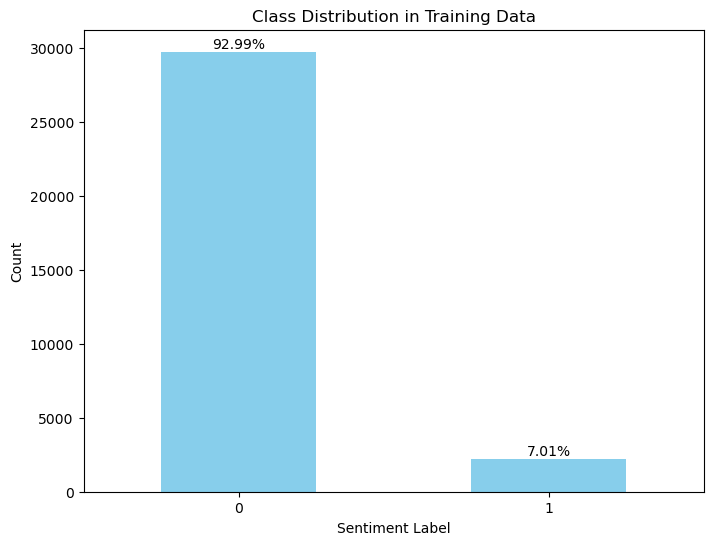

In [10]:
# Count the occurrences of each label
label_counts = df_train['label'].value_counts()

# Calculate the percentage of each class
total_samples = len(df_train)
label_percentages = (label_counts / total_samples) * 100

# Plotting the bar plot
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Annotate percentages on top of each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.5,
            f'{i.get_height()/total_samples:.2%}', ha='center', va='bottom')

plt.show()

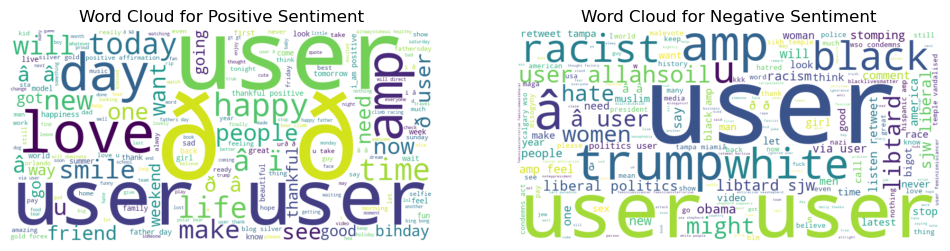

In [11]:
# Separate positive and negative sentiment tweets
positive_tweets = df_train[df_train['label'] == 0]['tweet']
negative_tweets = df_train[df_train['label'] == 1]['tweet']

# Generate word clouds for positive and negative sentiment tweets
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweets))

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.show()

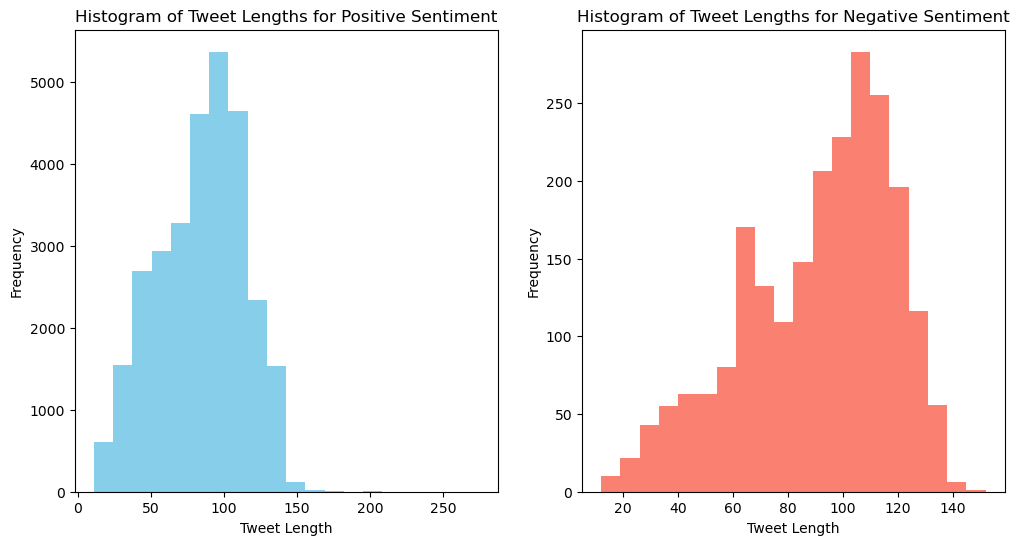

In [12]:
# Calculate tweet lengths for positive and negative sentiment tweets
positive_tweet_lengths = df_train[df_train['label'] == 0]['tweet'].apply(len)
negative_tweet_lengths = df_train[df_train['label'] == 1]['tweet'].apply(len)

# Plot histograms of tweet lengths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(positive_tweet_lengths, color='skyblue', bins=20)
plt.title('Histogram of Tweet Lengths for Positive Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(negative_tweet_lengths, color='salmon', bins=20)
plt.title('Histogram of Tweet Lengths for Negative Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.show()

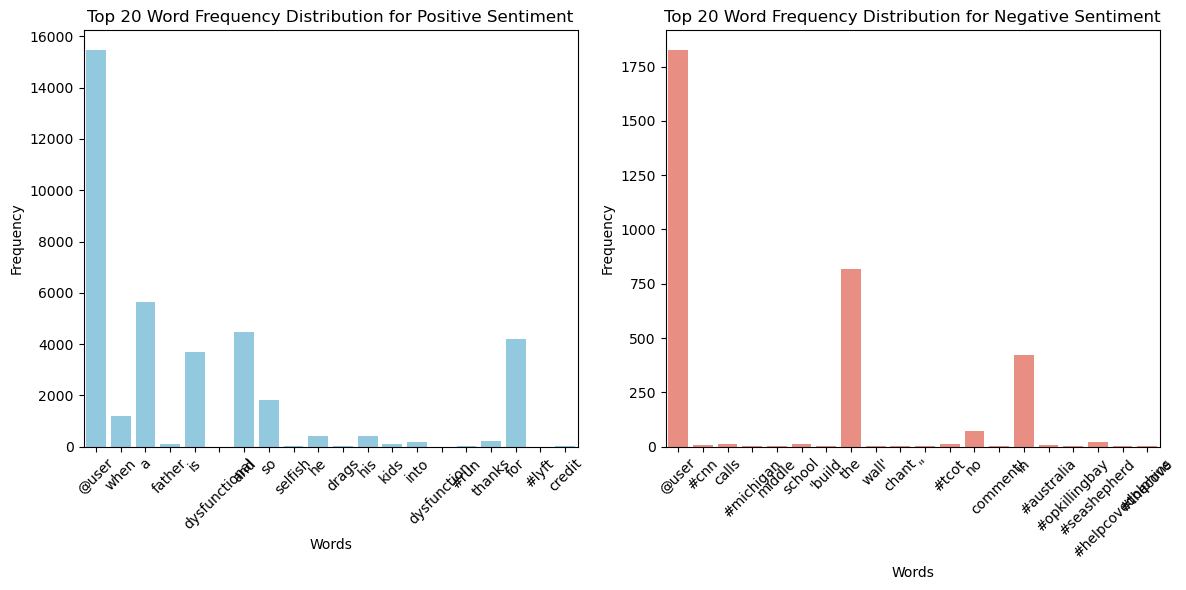

In [13]:
# Tokenize and count words for positive and negative sentiment tweets
positive_words = ' '.join(df_train[df_train['label'] == 0]['tweet']).split()
negative_words = ' '.join(df_train[df_train['label'] == 1]['tweet']).split()

# Count word frequencies
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

# Convert word frequencies to DataFrames
positive_word_freq_df = pd.DataFrame.from_dict(positive_word_freq, orient='index', columns=['Frequency'])
negative_word_freq_df = pd.DataFrame.from_dict(negative_word_freq, orient='index', columns=['Frequency'])

# Plot word frequency distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=positive_word_freq_df.index[:20], y=positive_word_freq_df['Frequency'][:20], color='skyblue')
plt.title('Top 20 Word Frequency Distribution for Positive Sentiment')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=negative_word_freq_df.index[:20], y=negative_word_freq_df['Frequency'][:20], color='salmon')
plt.title('Top 20 Word Frequency Distribution for Negative Sentiment')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [14]:
# Convert uppercase letters to lowercase in the "tweet" column
df_train['tweet'] = df_train['tweet'].str.lower()
df_test['tweet'] = df_test['tweet'].str.lower()

In [15]:
# Function to remove punctuation from text
def remove_punctuation(text):
    # Define a regular expression pattern to match punctuation
    punctuation_pattern = r'[^\w\s]'  # Matches any character that is not a word character or whitespace
    
    # Replace punctuation with an empty string
    return re.sub(punctuation_pattern, '', text)

# Remove punctuation from the "tweet" column
df_train['tweet'] = df_train['tweet'].apply(remove_punctuation)
df_test['tweet'] = df_test['tweet'].apply(remove_punctuation)

In [16]:
# Download stopwords list
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Function to remove numbers, stopwords from text
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

# Remove numbers, stopwords, and punctuations from the "tweet" column
df_train['tweet'] = df_train['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/terlan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Drop the "id" column from the training dataset
df_train = df_train.drop("id", axis=1)

# Drop the "id" column from the testing dataset
df_test = df_test.drop("id", axis=1)

In [18]:
# Tokenize words in the "tweet" column
words = ' '.join(df_train['tweet']).split()

# Count the frequency of each word
word_counts = Counter(words)

# Print the most frequent words
print("Most frequent words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

Most frequent words:
user: 17473
love: 2648
ð: 2516
day: 2230
â: 1867
happy: 1663
amp: 1588
u: 1141
im: 1139
time: 1110


In [19]:
# Function to remove specific characters and the word "user" from text
def clean_text(text):
    # Remove "user"
    text = text.replace('user', '')
    
    # Remove specific characters
    text = text.replace('ð', '')
    text = text.replace('â', '')
    
    return text

# Remove "user" and specific characters from the "tweet" column in the training dataset
df_train['tweet'] = df_train['tweet'].apply(clean_text)

# Remove "user" and specific characters from the "tweet" column in the testing dataset
df_test['tweet'] = df_test['tweet'].apply(clean_text)


In [20]:
# Step 1: Identify the rare words from the training dataset
word_counts = pd.Series(' '.join(df_train['tweet']).split()).value_counts()
least_common_words = word_counts[word_counts <= 1]  # Adjust the threshold as needed

# Step 2: Define a function to remove rare words
def rare_words_removal(df, rare_words):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(word for word in x.split() if word not in rare_words))
    return df

# Step 3: Apply the function to both the training and testing datasets
df_train = rare_words_removal(df_train, least_common_words.index)
df_test = rare_words_removal(df_test, least_common_words.index)

# Print the first few rows of the cleaned datasets
print(df_train['tweet'].head())
print(df_test['tweet'].head())

0            father selfish drags kids dysfunction run
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: tweet, dtype: object
0    studiolife aislife requires passion dedication...
1        white want everyone see new birds movie heres
2    safe ways heal acne altwaystoheal healthy healing
3    hp child book reservations already yes harrypo...
4    rd bihday amazing hilarious nephew eli ahmir u...
Name: tweet, dtype: object


In [21]:
#Faster method of spelling correction
#Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load a frequency dictionary
dictionary_path = "frequency_dictionary_en_82_765.txt"  # Example dictionary file path
bigram_path = "frequency_bigramdictionary_en_243_342.txt"  # Example bigram dictionary file path
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Function to correct spelling using SymSpell
def correct_spelling(text):
    corrected_text = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_text.append(suggestions[0].term)
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)

# Assuming df_train and df_test are your DataFrames

# Apply the spelling correction function to both the training and testing datasets
df_train['tweet'] = df_train['tweet'].apply(correct_spelling)
df_test['tweet'] = df_test['tweet'].apply(correct_spelling)

# Print the first few rows of the cleaned datasets
print(df_train['tweet'].head())
print(df_test['tweet'].head())

2024-05-29 15:31:06,605: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.
2024-05-29 15:31:06,606: E symspellpy.symspellpy] Bigram dictionary file not found at frequency_bigramdictionary_en_243_342.txt.


0            father selfish drags kids dysfunction run
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: tweet, dtype: object
0    studiolife aislife requires passion dedication...
1        white want everyone see new birds movie heres
2    safe ways heal acne altwaystoheal healthy healing
3    hp child book reservations already yes harrypo...
4    rd bihday amazing hilarious nephew eli ahmir u...
Name: tweet, dtype: object


In [22]:
#Tokenization
# Download NLTK resources 
nltk.download('punkt')

# Assuming df_train and df_test are your DataFrames

# Tokenize the "tweet" column in the training dataset
df_train['tokenized_tweet'] = df_train['tweet'].apply(word_tokenize)

# Tokenize the "tweet" column in the testing dataset
df_test['tokenized_tweet'] = df_test['tweet'].apply(word_tokenize)

# Print the first few rows of the tokenized datasets
print(df_train['tokenized_tweet'].head())
print(df_test['tokenized_tweet'].head())

[nltk_data] Downloading package punkt to /Users/terlan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     [father, selfish, drags, kids, dysfunction, run]
1    [thanks, lyft, credit, cant, use, cause, dont,...
2                                    [bihday, majesty]
3                  [model, love, u, take, u, time, ur]
4                    [factsguide, society, motivation]
Name: tokenized_tweet, dtype: object
0    [studiolife, aislife, requires, passion, dedic...
1    [white, want, everyone, see, new, birds, movie...
2    [safe, ways, heal, acne, altwaystoheal, health...
3    [hp, child, book, reservations, already, yes, ...
4    [rd, bihday, amazing, hilarious, nephew, eli, ...
Name: tokenized_tweet, dtype: object


In [23]:
#Applying TF-IDF
def compute_tf(texts):
    tf_scores = []
    for text in texts:
        tokens = nltk.word_tokenize(text)
        counter = Counter(tokens)
        total_words = len(tokens)
        tf_scores.append({word: count / total_words for word, count in counter.items()})
    return tf_scores

def compute_idf(texts):
    num_docs = len(texts)
    word_doc_count = Counter()
    for text in texts:
        tokens = set(nltk.word_tokenize(text))
        word_doc_count.update(tokens)
    idf_scores = {word: np.log(num_docs / (count + 1)) for word, count in word_doc_count.items()}
    return idf_scores

def compute_tfidf(tf_scores, idf_scores):
    tfidf_scores = []
    for tf in tf_scores:
        tfidf_scores.append({word: tf[word] * idf_scores[word] for word in tf.keys()})
    return tfidf_scores

# Sample dataset
texts = df_train['tweet'].tolist()

# Compute TF and IDF
tf_scores = compute_tf(texts)
idf_scores = compute_idf(texts)

# Compute TF-IDF
tfidf_scores = compute_tfidf(tf_scores, idf_scores)

# Convert to sparse matrix format for compatibility with ML models
def to_sparse_matrix(tfidf_scores, feature_names):
    rows, cols, data = [], [], []
    for row, tfidf in enumerate(tfidf_scores):
        for word, score in tfidf.items():
            rows.append(row)
            cols.append(feature_names.index(word))
            data.append(score)
    return coo_matrix((data, (rows, cols)), shape=(len(tfidf_scores), len(feature_names)))

feature_names = sorted(idf_scores.keys())
X = to_sparse_matrix(tfidf_scores, feature_names)
y = df_train['label']

In [26]:
for i, row in enumerate(tfidf_scores[:5]):
    print(f"Tweet {i+1}:")
    for word, score in row.items():
        print(f"  {word}: {score:.4f}")

# Convert the sparse matrix to a dense array for the first few entries and print
dense_X = X.todense()[:5]
print("\nDense Matrix Representation (First 5 entries):")
print(dense_X)

Tweet 1:
  father: 0.8596
  selfish: 1.3450
  drags: 1.4605
  kids: 0.8525
  dysfunction: 1.5456
  run: 0.9612
Tweet 2:
  thanks: 0.3893
  lyft: 0.7150
  credit: 0.6333
  cant: 0.3072
  use: 0.4682
  cause: 0.5068
  dont: 0.3178
  offer: 0.5897
  wheelchair: 0.7488
  vans: 0.7728
  pdx: 0.7488
  getthanked: 0.7728
Tweet 3:
  bihday: 1.9156
  majesty: 3.9872
Tweet 4:
  model: 0.6354
  love: 0.3604
  u: 1.0833
  take: 0.5651
  time: 0.4822
  ur: 0.6116
Tweet 5:
  factsguide: 2.6025
  society: 2.3714
  motivation: 1.7339

Dense Matrix Representation (First 5 entries):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
